### Introduction to Knoweldge Graphs

- CS 575
- Mike Goodrich
- Brigham Young University
- March 2025

The purpose of this tutorial is to introduce the basics of knowledge graphs. We'll use data from the [Kaggle movies dataset](https://www.kaggle.com/datasets/rajugc/imdb-top-250-movies-dataset) and [Kaggle movies code example](https://www.kaggle.com/code/rajugc/imdb-top-250-movies-eda). The code is released under the Apache 2.0 open source license.

This tutorial uses some of the code from the Kaggle data set, but also uses code patterned after chapter 2 in _Graph Data Science with Neo4j_, Estell Scifo, Packt Publiching Ltd., 2023.

---

#### Requirements

The code requires the following modules
- os
- matplotlib
- pandas
- the network partitioning code used class
- the network visualization code used in class
- the movies database csv file in the `movies_data` subdirectory
- three figures in the `figures` subdirectory

---

#### Graph Data Science Process

DISCLAIMER: Graph data science is a relatively new area for me. This means that you should view the process I present as my working mental model rather than something that you should treat as some kind of universal approach.

The following figure is a flowchart of my mental model of the graph data science process. 

<img src="figures/Graph_data_science_process.png" alt="A flowchart of the data science process" width = "500">


#### Gather and Clean Data

The first step is to extract data from whatever source you have into usable form. This could require desiging a webcrawler to scrape Netflix recommendations, interfacing through an API to obtain Twitter interaction networks, writing a parser to turn a set of Google scholar pages into csv file, or querying an existing cloud database to find how topics on Wikipedia are related.  This can be labor-intensive and can require a high level of skill, but fortunately there are now many AI-based tools that help a lot with this process. 

We'll use the _movies dataset_ from the Kaggle project, so let's get familiar with it.


**Inspect some rows and columns in the dataset**

In [152]:
import pandas as pd

df: pd.DataFrame = pd.read_csv('movies_data/IMDB Top 250 Movies.csv') # prefix this file name with the directory in which you stored it
df.head()   # This function returns the first n rows for the object based on position. 
            # It is useful for quickly testing if your object has the right type of data in it.
            # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000,1006234167,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer"
3,4,The Godfather Part II,1974,9.0,"Crime,Drama",R,3h 22m,All the power on earth can't change destiny.,13000000,47961919,"Al Pacino,Robert De Niro,Robert Duvall,Diane K...",Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo"
4,5,12 Angry Men,1957,9.0,"Crime,Drama",Approved,1h 36m,Life Is In Their Hands -- Death Is On Their Mi...,350000,955,"Henry Fonda,Lee J. Cobb,Martin Balsam,John Fie...",Sidney Lumet,Reginald Rose


**Look up the headers for each column in the dataset**

In [153]:
print(list(df.columns))

['rank', 'name', 'year', 'rating', 'genre', 'certificate', 'run_time', 'tagline', 'budget', 'box_office', 'casts', 'directors', 'writers']


**Inspect what kind of information is stored in each column of the dataset**

In [154]:
df.info()
# This method prints information about a DataFrame including the index dtype and 
# columns, non-null values and memory usage.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         250 non-null    int64  
 1   name         250 non-null    object 
 2   year         250 non-null    int64  
 3   rating       250 non-null    float64
 4   genre        250 non-null    object 
 5   certificate  250 non-null    object 
 6   run_time     250 non-null    object 
 7   tagline      250 non-null    object 
 8   budget       250 non-null    object 
 9   box_office   250 non-null    object 
 10  casts        250 non-null    object 
 11  directors    250 non-null    object 
 12  writers      250 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 25.5+ KB


Pull this information into a set

In [155]:
column_list: list[str] = df.columns.tolist()
print(column_list)

['rank', 'name', 'year', 'rating', 'genre', 'certificate', 'run_time', 'tagline', 'budget', 'box_office', 'casts', 'directors', 'writers']


**Look at some summary information about which genres are present in the _genres_ column**

In [156]:
df.value_counts('genre')

genre
Drama                         19
Crime,Drama                   14
Animation,Adventure,Comedy    10
Biography,Drama,History        9
Crime,Drama,Mystery            9
                              ..
Crime,Mystery,Thriller         1
Crime,Sci-Fi                   1
Adventure,Comedy,Sci-Fi        1
Adventure,Comedy,Fantasy       1
Adventure,Comedy,Drama         1
Name: count, Length: 104, dtype: int64

What kind of info is stored in `certificate` and is it always populated?

In [157]:
certificate_set: set[str] = set()
for i in df['certificate']:
    certificate_set.add(i)
print(certificate_set)

{'GP', '13+', '18+', 'PG-13', 'PG', 'TV-PG', 'Not Rated', 'Unrated', 'X', 'G', 'Approved', 'Passed', 'Not Available', 'TV-MA', 'R'}


---

#### Create Graph Schema

A _graph database_ is just a graph model of the database. The naive way to construct the graph database is to create a node for each row and column entry, and then add edges between nodes on the same row. In practice, this is not effective because only some of the relationships between the data in the columns is of interest. 

We approach this by creating a schema that describes the relationships that we care about (see Neo4j book, page 31). The schema should be set up in a way that allows us to answer questions that we might ask. For the movie database, I'll use the following schema.

<img src="figures/GraphSchema.png" alt="Grapha schema for the movies database" width = "500">

This schema emphasizes movies, genres, and ratings. Notice how it ignores several of the columns in the database. Choosing a graph schema is the process of identifying the entities and relationships that you care about in the graph database.

What schemas can you construct that might tell us interesting things about the movies dataset?

---

#### Form Knowledge Graph

We now need to go through the database and create a node for each movie, genre, movie certificate, and person. There are graph database query tools for doing this (e.g., Cypher in Neo4j), but I'm trying to teach this without requiring you to learn a lot of new tools, so I wrote code that extracts movie information into _nodes_. Each node will have metadata, describing some of the infromation for what the node represents. 

We'll then create _edges_ using the "resource description framework" (RDF), which represents relationships between nodes using a _subject predicate object_ relationship template. Don't worry too much about what this means right now because I haven't implemented edge labeling in my code. 

**Create Graph:** The edge types in the graph schema are directed, but the relationship between items in the database is undirected. We'll create an undirected graph. If we were labeling edge types, we'd need to create a directed graph because `actor "is_in" movie` differs from `movie "had_in_it" actor`. 


In [158]:
import networkx as nx
G: nx.Graph = nx.Graph()

**Get Nodes:** The database has 13 columns, but our graph schema indicates that we are only interested in four: genre, movie, certification, and person. Define a function that takes a list of categories and creates a node for each type.

In [159]:
from typing import Tuple
def get_nodes_from_categories(category_list: list[str],
                              dataframe: pd.DataFrame,
                              G: nx.Graph
                              ) -> Tuple[nx.Graph, dict[str, int]]:
    """ 
        Take an empty graph and populate it with nodes.
        Inputs
          • category_list is a list of headers in the dataframe
          • dataframe is a pandas dataframe
          • G is a graph with no edges and no nodes
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • A dictionary that allows the node number to be looked up from the node_value
        Note attributes
          • The node type is a string. If the node belongs to more than one category
            then the string is the concatenation of categories separated by commas 
    """

    # Error checks
    if len(G) > 0:
        raise ValueError("Graph must be empty")
    if len(set(category_list) - set(df.columns.tolist())) > 0:
        raise ValueError(f"The following categories aren't in the dataframe: {set(category_list) - set(df.columns.tolist())}")

    node_num: int = 0
    node_values_to_node_num: dict[str, int] = dict()
    # For each category in the list of categories of interest
    for category in category_list:
        # Get the list of unique values from each cell in the dataframe column
        node_list: list[str] = get_nodes_from_category(category, dataframe)
        for node_value in node_list:
            # If the node_value is already in the graph, don't add it again
            # Rather, update the node_type information by appending the new category
            if node_value in node_values_to_node_num.keys():
                this_node_num: int = node_values_to_node_num[node_value]
                G.nodes[this_node_num]["node_type"] += "," + str(category)
            else:
                G.add_node(node_num, node_value = str(node_value), node_type=str(category))
                node_values_to_node_num[node_value] = node_num
                node_num += 1
    return G, node_values_to_node_num

def get_nodes_from_category(category: str,
                            dataframe: pd.DataFrame
                            ) -> list[str]:
    # Error handling
    if category not in set(df.columns):
        raise ValueError(f"Category {category} not found in the database")
    
    # Read each line in the category column
    entries = dataframe[category] 
    # There can be multiple objects listed in each line. Find the unique ones 
    entry_set: set[str] = set()
    
    for entry in entries:
        # Don't split movie titles by commas 
        # "The good, the bad, and the ugly" is one movie
        if category == "name": 
            entry_set.add(entry)
        else: # Split casts, writers, etc by commas
            for e in entry.replace('\n',',').split(","):
                entry_set.add(e)
    return sorted(list(entry_set))


The graph gets too big to visualize efficiently if all top 250 movies are used. Let's restrict it to the top 25 movies.

In [160]:
df_restricted: pd.DataFrame = df.head(25)
print(df_restricted.shape)

(25, 13)


In [161]:
categories: set[str] = {'genre', 'name', 'casts', 'directors', 'writers','certificate'}
G: nx.Graph = nx.Graph()
G, node_value_to_node_number = get_nodes_from_categories(categories,df_restricted,G) 
print(f"The graph has {len(G)} nodes")

The graph has 510 nodes


There are a lot of nodes in the graph so drawing it will be slow, so let's do a really simple graph layout.

In [162]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def show_graph(G: nx.Graph, 
               categories: list[str],
               title: str = "Graph from pandas dataframe"
               ) -> None:
    color_template: dict[str, str] = {'genre': 'lightblue', 
                                    'writers': 'y', 
                                    'name': 'salmon', 
                                    'casts': 'm', 
                                    'directors': 'c',
                                    'certificate': 'olive',
                                    'person': 'm',
                                    'combo': 'k'}
    # Need to add error checking. That is where the categories argument will be used
    node_colors: list[str] = []
    for node in G.nodes():
        if G.nodes[node]['node_type'] == 'name':
            node_colors.append(color_template['name'])
        elif len(G.nodes[node]['node_type'].split(",")) > 1:
            node_colors.append(color_template['combo'])
        else:
            node_colors.append(color_template[G.nodes[node]['node_type']])

    plt.figure()
    #pos = nx.spring_layout(G)
    #pos = nx.nx_pydot.pydot_layout(G, prog="neato")
    pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
    nx.draw_networkx_nodes(G, pos, node_color = node_colors, alpha=0.5,node_size=20 )
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=0.5)
    
    # create legend
    legend_patches = [mpatches.Patch(color=color, label=category) for category, 
                    color in color_template.items() if category in categories]
    if "k" in node_colors:
        legend_patches.append(mpatches.Patch(color=color_template["combo"],label="combo"))
    # Add the legend
    _ = plt.legend(handles=legend_patches, title="Node Types", loc="best")

    # Add the title
    _ = plt.title(title)
    _ = plt.axis('off')

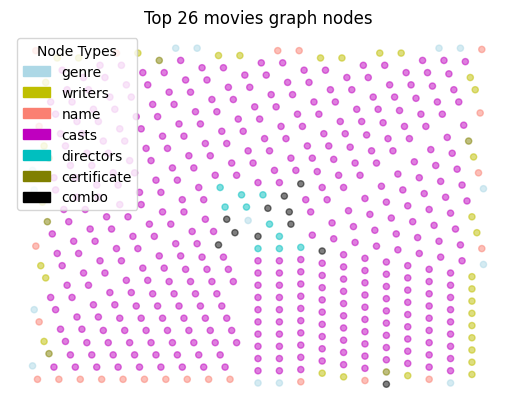

In [163]:
show_graph(G, categories, title="Top 26 movies graph nodes")

**Add Edges:** There should be an edge between every pair of nodes that occur on the same line of the database. 

In [164]:
def get_edges(category_1: str,
              category_2: str,
              df: pd.DataFrame
              ) -> list[tuple[str, str]]:
    # Step 1: Error handling
    if category_1 not in set(df.columns):
        raise ValueError(f"Category {category_1} not found in the database")
    if category_2 not in set(df.columns):
        raise ValueError(f"Category {category_2} not found in the database")
    if category_1 == category_2:
        raise ValueError(f"Category 1 and category 2 are the same: {category_1}")
    
    # Step 2: identify pairwise relationships
    entries_1 = df[category_1]
    entries_2 = df[category_2]
    set_of_edges = set()
    for i in range(len(entries_1)):
        # Don't split movie titles by commas 
        # "The good, the bad, and the ugly" is one movie
        if category_1 == "name": 
            iterator_1 = {entries_1[i],}
        else: 
            iterator_1 = set(entries_1[i].replace('\n',',').split(","))
        if category_2 == "name": 
            iterator_2 = {entries_2[i],}
        else: 
            iterator_2 = set(entries_2[i].replace('\n',',').split(","))
        for node_value_1 in iterator_1:
            for node_value_2 in iterator_2:
                set_of_edges.add((str(node_value_1),str(node_value_2)))
    return set_of_edges

    

In [165]:
from itertools import combinations
from typing import Hashable

def add_edges(categories: set[str], 
              node_value_to_node_number: dict[str, int],
              df: pd.DataFrame, 
              G: nx.Graph
              ) -> nx.Graph:
    for category_1, category_2 in list(combinations(categories,2)):
        for edge in get_edges(category_1, category_2, df):
            #G.add_edge(edge[0],edge[1])
             node0 = node_value_to_node_number[edge[0]]
             node1 = node_value_to_node_number[edge[1]]
             if node0 is None:
                 print(f"{node0} from {edge[0]} wasn't found in category {category_1}")
                 continue
             if node1 is None:
                 print(f"{node1} from {edge[1]} wasn't found in category {category_2}")
                 continue
             G.add_edge(node0, node1)
    return G

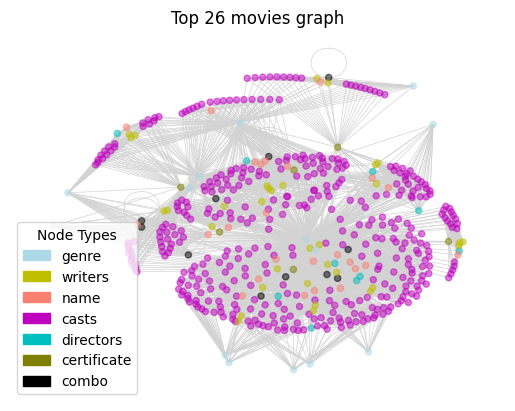

In [166]:
G = add_edges(categories, node_value_to_node_number, df_restricted, G)
show_graph(G, categories, title="Top 26 movies graph")


With just movie names, casts, directors, and writers

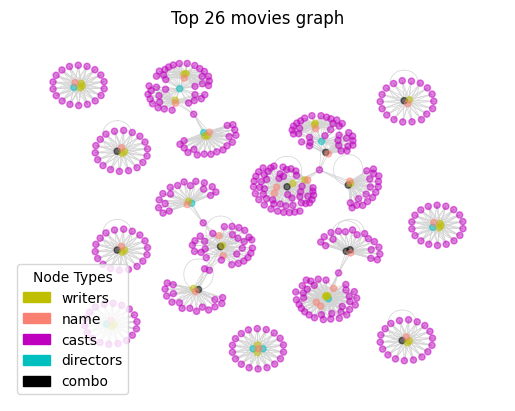

In [167]:
categories = {"name", "casts", "writers", "directors"}
G: nx.Graph = nx.Graph()
G, node_value_to_node_number = get_nodes_from_categories(categories,df_restricted,G) 
G = add_edges(categories, node_value_to_node_number, df_restricted, G)
show_graph(G, categories, title="Top 26 movies graph")

---

#### Biadjacency Matrices

The network above doesn't actually match the graph schema since it shows nodes with types writers, directors, and cast members. The graph schema says that we should lump people in these categories into a generic type called _person_.  This section of the tutorial explores different types of graph operations. 

I'm going to use the term _projection_ for these different kinds of graph operations, though I don't think most people would agree with my use of this term. We'll look at a very specific type of projection which can be performed using incidence matrices. This kind of projection is technically called a _one-mode projection_, so I'm going to use the term _projection_ as a kind of "catch all" term to mean I'm going to manipulate the graph in some way to help me understand more about it.

The key to each type of projection is to notice that each node is in one of a set of unique classes. In other words, all nodes in the same `node_type` form a subset of all nodes. Splitting up nodes into different subsets according to their node_type forms a _partition_ of the set. The projections we will discuss operate on the different classes within a partition.

**Bipartitie Graphs:** Recall that a bipartite network is a graph where nodes can be partitioned into two classes. Edges only form between nodes in different classes, and never form between nodes from within the same class. We can construct bipartite graphs for any of the categories in our database as long as there is a node between the categories. For example, we can construct a bipartite graph with what actors are in what movies.

437


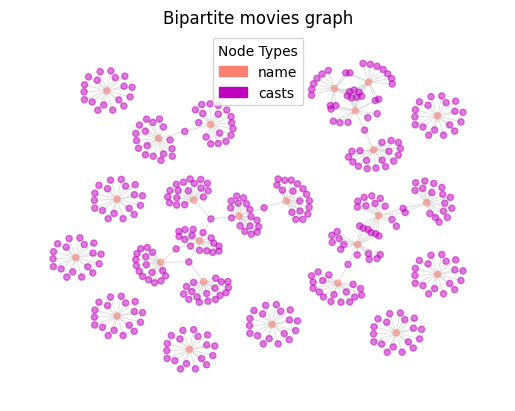

In [168]:
categories: set[str] = {'name', 'casts'}
G_name_cast: nx.Graph = nx.Graph()
G_name_cast, node_value_to_node_number = get_nodes_from_categories(categories, df_restricted, G_name_cast) 
G_name_cast = add_edges(categories, node_value_to_node_number, df_restricted, G_name_cast)

print(len(G_name_cast))
show_graph(G_name_cast, categories, title = "Bipartite movies graph")

432


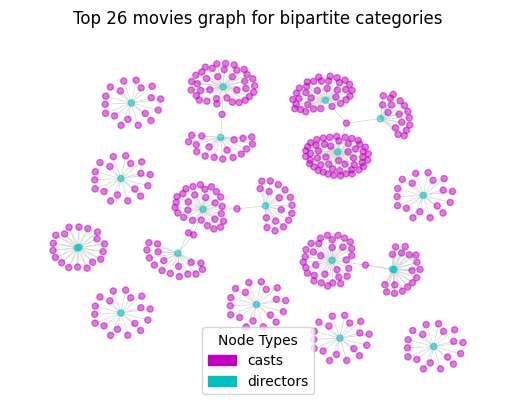

In [169]:
categories: set[str] = {'directors', 'casts'}
G_director_cast: nx.Graph = nx.Graph()
G_director_cast, node_value_to_node_number = get_nodes_from_categories(categories, df_restricted, G_director_cast) 
G_director_cast = add_edges(categories, node_value_to_node_number, df_restricted, G_director_cast)

print(len(G_director_cast))
show_graph(G_director_cast, categories, title = "Top 26 movies graph for bipartite categories")

69


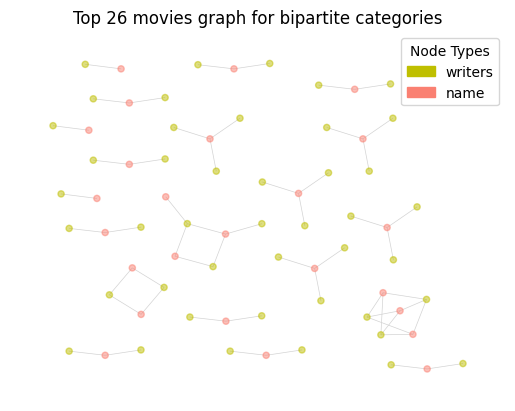

In [170]:
categories: set[str] = {'name', 'writers'}
G_name_writer: nx.Graph = nx.Graph()
G_name_writer, node_value_to_node_number = get_nodes_from_categories(categories, df_restricted, G_name_writer) 
G_name_writer = add_edges(categories, node_value_to_node_number, df_restricted, G_name_writer)

print(len(G_name_writer))
show_graph(G_name_writer, categories, title = "Top 26 movies graph for bipartite categories")

**Bipartite Graph Representations:** ry to recall when we talked about bipartite graphs near the start of the semester. We were able to come up with a special type of matrix representation. The rows represented vertices in the first partition and the columns represented vertices in the second partition.

<img src="figures/BipartiteGraph_IncidenceMatrix.png" alt="Special form of the incidence matrix for a bipartite graph" width = "500">



I made a mistake in class. I called this form of matrix $B$ a special form of the incidence matrix. That is wrong. It is actually called the _bi-adjacency_ matrix because it is a form of the adjacency matrix applicable to bipartite graphs. 

We can define bi-adjacency matrix formally. I'm using the definition from Chat-GPT in response to the prompt "what is a bi-adjacency matrix". The example is updated to use the movies database.

A _bi-adjacency matrix+ (or bipartite adjacency matrix) is a matrix representation of a bipartite graph. In a bipartite graph, the set of nodes is divided into two disjoint sets, U and V, where edges only exist between nodes from different sets (i.e., there are no edges within U or within V).

**Definition of Biadjacency Matrix**

Given a bipartite graph $G = (U, V, E)$, the bi-adjacency matrix $B$ is a $|U| \times |V|$ matrix where:

$$
B[i][j] =
\begin{array}{rl}
1 & \text{if there is an edge between } u_i \in U \text{ and } v_j \in V, \\
0 & \text{otherwise}.
\end{array}
$$


**Example of Biadjacency Matrix**

Consider a bipartite graph with:
  - Set $U$ (Movies): $\{A, B, C\}$
  - Set $V$ (Writers): $\{X, Y\}$
  - Edges: $\{(A, X), (A, Y), (B, X), (C, Y)\}$

The bi-adjacency matrix $B$ would be:

$$
B =
\begin{bmatrix}
1 & 1 \\
1 & 0 \\
0 & 1
\end{bmatrix}
$$

where:
  - Rows correspond to Users $\{A, B, C\}$
  - Columns correspond to Channels $\{X, Y\}$
  - 1 indicates an edge exists between the corresponding user and channel.


**Biadjacency Matrix in Code**

Let's add a function that creates the bi-adjacency matrix for the movies and casts graph.

In [171]:
import numpy as np
from numpy.typing import NDArray
def get_biadjacency_matrix(G: nx.Graph,
                           categories: list[str]
                           ) -> NDArray[np.float32]:
    # Error handling
    if len(categories) != 2:
        raise ValueError("A biadjacency matrix can only be created \nfrom an ordered list of two categories")
    
    # Get list of nodes from each node partition
    list_0: list[Hashable] = [node for node, attrs in G.nodes(data=True) if categories[0] in set(attrs.get("node_type").split(","))] 
    if len(list_0) == 0:
        raise ValueError(f"There are no nodes from category {categories[0]} in the graph")
    list_1: list[Hashable] = [node for node, attrs in G.nodes(data=True) if categories[1] in set(attrs.get("node_type").split(","))] 
    if len(list_1) == 0:
        raise ValueError(f"There are no nodes from category {categories[1]} in the graph")

    biadjacency_matrix:NDArray = nx.bipartite.biadjacency_matrix(G, 
                                                                 row_order=list_0, 
                                                                 column_order=list_1).toarray()
    return biadjacency_matrix


Gather the bi-adjacency matrix for movie names and cast members

In [172]:
categories: list[str] = ["name","casts"] # notice that this is now an ordered object
B_name_cast = get_biadjacency_matrix(G_name_cast, categories)
print(B_name_cast)
print(f"The shape of B for {categories[0]} and {categories[1]} is {B_name_cast.shape}")


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
The shape of B for name and casts is (25, 412)


Gather the bi-adjacency matrix for movie names and directors

In [173]:
categories: list[str] = ["name","directors"] # notice that this is now an ordered object
G_name_director: nx.Graph = nx.Graph()
G_name_director = get_nodes_from_categories(categories, df_restricted, G_name_director) 
G_name_director = add_edges(categories, df_restricted, G_name_director)
B_name_director = get_biadjacency_matrix(G_name_director, categories)
#print(B_name_director)
print(f"The shape of B for {categories[0]} and {categories[1]} is {B_name_director.shape}")

TypeError: add_edges() missing 1 required positional argument: 'G'

Gather the bi-adjacency matrix for movie names and writers

In [ ]:
categories: list[str] = ["name","writers"]
B_name_writer = get_biadjacency_matrix(G_name_writer, categories)
#print(B_name_director)
print(f"The shape of B for {categories[0]} and {categories[1]} is {B_name_writer.shape}")

The shape of B for name and writers is (25, 44)


---

#### Knowledge Graph Queries via Matrix Operations

We can do graph queries using matrix operations.  We'll explore three:
- union
- projection
- composition

These are my terms that I've adapted from more common usage, so don't look for them in the literature.

**Union** 

Notice that there are the same number of rows in each of the three matrices. Why? Because in the biadjacency matrices, the rows correspond to the names of the movies.

This leads to a way of joining the _writers_, _directors_, and _cast members_ classes into a single class called _persons_. We can do this by simply "or"-ing the matrices together.

$$ B_{\text{movie, person}} = B_{\text{movie, cast}} \vee B_{\text{movie, director}} \vee B_{\text{movie, writer}} $$

We can try to do this naively, and we'll create an error.

In [ ]:
try:
    B = B_name_cast | B_name_director | B_name_writer
except ValueError as e:
    print(f"ValueError: {e}")


ValueError: operands could not be broadcast together with shapes (25,412) (25,20) 


The reason for the error is that the matrices don't have the same number of columns. We need to define the columns such that there is one column for each actor, writer, or director in the graph. I'm not going to do that right now, but instead I'll just gather the bipartite graph directly.

In [174]:
person_types: set[str] = {"directors", "casts", "writers"}
categories: set[str] = {"name"} | person_types # notice that this is now an ordered object
G_name_person: nx.Graph = nx.Graph()
G_name_person, node_value_to_node_number = get_nodes_from_categories(categories, df_restricted, G_name_person) 
G_name_person = add_edges(categories, node_value_to_node_number, df_restricted, G_name_person)
for node, attrs in G_name_person.nodes(data=True):
    if set(attrs.get("node_type").split(",")) <= person_types: # <= is shorthand for is subset
        attrs["node_type"] = "person"
print(G_name_person.nodes(data=True))

[(0, {'node_value': 'Akira Kurosawa', 'node_type': 'person'}), (1, {'node_value': 'Christopher Nolan', 'node_type': 'person'}), (2, {'node_value': 'David Fincher', 'node_type': 'person'}), (3, {'node_value': 'Fernando Meirelles', 'node_type': 'person'}), (4, {'node_value': 'Francis Ford Coppola', 'node_type': 'person'}), (5, {'node_value': 'Frank Capra', 'node_type': 'person'}), (6, {'node_value': 'Frank Darabont', 'node_type': 'person'}), (7, {'node_value': 'Irvin Kershner', 'node_type': 'person'}), (8, {'node_value': 'Jonathan Demme', 'node_type': 'person'}), (9, {'node_value': 'Kátia Lund(co-director)', 'node_type': 'person'}), (10, {'node_value': 'Lana Wachowski', 'node_type': 'person'}), (11, {'node_value': 'Lilly Wachowski', 'node_type': 'person'}), (12, {'node_value': 'Martin Scorsese', 'node_type': 'person'}), (13, {'node_value': 'Milos Forman', 'node_type': 'person'}), (14, {'node_value': 'Peter Jackson', 'node_type': 'person'}), (15, {'node_value': 'Quentin Tarantino', 'node_

Draw the graph

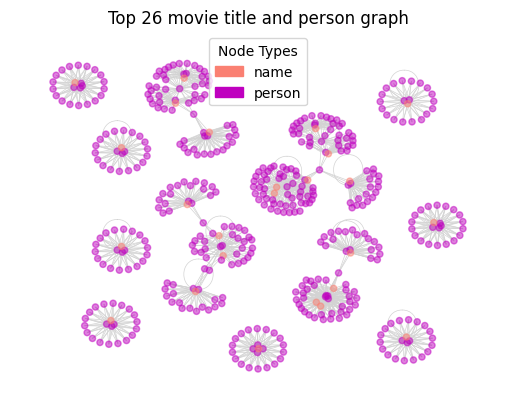

In [175]:
show_graph(G_name_person,categories={"name","person"},title="Top 26 movie title and person graph" )

---

**Projection**

The second matrix operation that can be used to do graph queries is _projection_. More technically, it's called _one mode projection_. 

Suppose we want to know who knows whom? We can't tell that from the knowlede graph database, but we can make inferences. Let's suppose that any writer, director, or actor who worked on the same movie. The previous cells produced the graph that we need. Let's construct the biadjacency matrix for which persons worked on which movies.  

In [176]:
categories: list[str] = ["name","person"]
B_name_person = get_biadjacency_matrix(G_name_person, categories)

Notice that the rows of the biadjacency matrix correspond to the the movie name and that the rows correspond to the columns. When we take the transpose of the biadjacency matrix with itself we learn who knows whom. Let's drop the full category names for the matrices and just go with the first letter of the category: "p"erson, "n"ame

$$ B_{\text{p, p}} = B_{\text{n, p}}^T B_{\text{n, p}} $$

In [177]:
A = B_name_person.T@B_name_person
print(A)

[[1 0 0 ... 1 1 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 1]
 ...
 [1 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]
 [0 0 1 ... 0 0 1]]


Get rid of self loops

In [178]:
np.fill_diagonal(A, 0)
print(A)

[[0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]]


We want this to be an adjacency matrix so turn anything bigger than 1 to 1.

In [179]:
A[A > 1] = 1
print(A)

[[0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]]


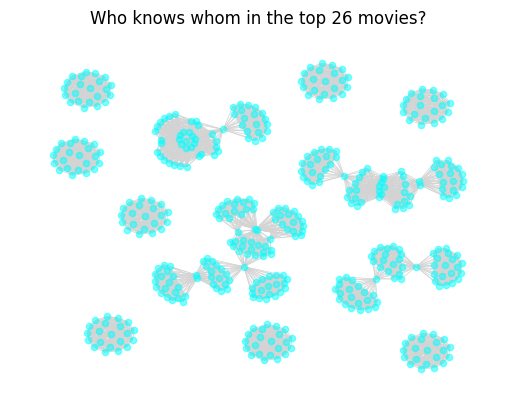

In [181]:
G_person_person: nx.Graph  = nx.from_numpy_array(A)
plt.figure()
#pos = nx.spring_layout(G_person_person)
pos = nx.nx_pydot.graphviz_layout(G_person_person,prog="neato")
nx.draw_networkx_nodes(G_person_person, pos, node_color = 'cyan', alpha=0.5,node_size=20 )
nx.draw_networkx_edges(G_person_person, pos, edge_color="lightgray", width=0.5)
_ = plt.title("Who knows whom in the top 26 movies?")
_ = plt.axis('off')

In [183]:
print(nx.number_connected_components(G_person_person))

12


Show only the largest component

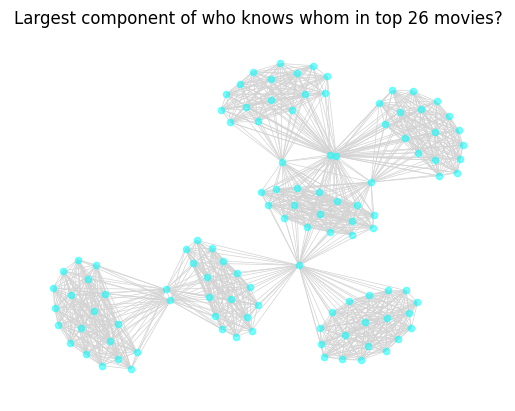

In [184]:
largest_cc = max(nx.connected_components(G_person_person), key=len)

# Create a subgraph with only the largest component
largest_subgraph = G_person_person.subgraph(largest_cc).copy()
plt.figure()
pos = nx.nx_pydot.pydot_layout(largest_subgraph, prog="neato")
nx.draw_networkx_nodes(largest_subgraph, pos, node_color = 'cyan', alpha=0.5,node_size=20 )
nx.draw_networkx_edges(largest_subgraph, pos, edge_color="lightgray", width=0.5)
_ = plt.title("Largest component of who knows whom in top 26 movies?")
_ = plt.axis('off')

Find Louvain partitions

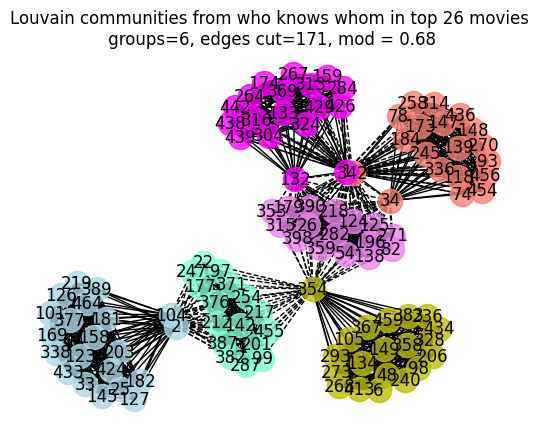

In [185]:
from drawing_utilities import show_partitions
partition = nx.community.louvain_communities(largest_subgraph)
show_partitions(largest_subgraph, 
                partition, 
                title = "Louvain communities from who knows whom in top 26 movies\n")

**Composition**

What if we want to know something else about the actors, specifically which actors tend to act in which genres. We can do this using composition. Let's retrieve the bipartite graph for genres and movies. 

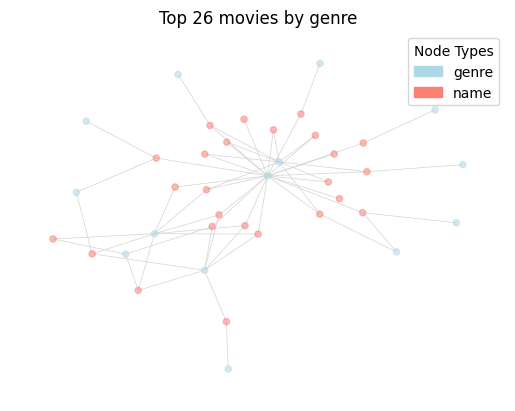

In [187]:
categories: list[str] = ["genre","name"] # notice that this is now an ordered object
G_genre_name: nx.Graph = nx.Graph()
G_genre_name, node_value_to_node_number = get_nodes_from_categories(categories, df_restricted, G_genre_name) 
G_genre_name = add_edges(categories, node_value_to_node_number, df_restricted, G_genre_name)
show_graph(G_genre_name, categories, title="Top 26 movies by genre")

Get the bipadjacency matrix

In [188]:
categories: list[str] = ["genre","name"]
B_genre_name = get_biadjacency_matrix(G_genre_name, categories)

We have two biadjacency matrices that are related: 
- connections between genres and movie names
- connections betwee movie names and persons

If we take the product of these to matrices, we "project out" the movie names.

In [189]:
B_genre_person = B_genre_name@B_name_person
print(B_genre_person.shape)

(14, 465)


And use matrix operations to form the one-mode projection

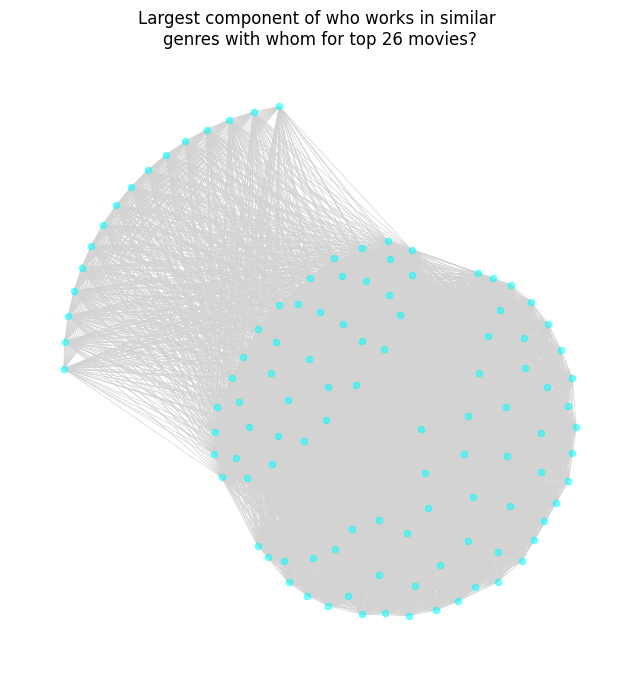

In [192]:
A_pp = B_genre_person.T@B_genre_person
np.fill_diagonal(A_pp, 0)
A_pp[A_pp>1] = 1
G_pp: nx.Graph  = nx.from_numpy_array(A_pp)
largest_subgraph = G_pp.subgraph(largest_cc).copy()
plt.figure(figsize=(8,8))
pos = nx.nx_pydot.graphviz_layout(largest_subgraph, prog="neato")
nx.draw_networkx_nodes(largest_subgraph, pos, node_color = 'cyan', alpha=0.5,node_size=20 )
nx.draw_networkx_edges(largest_subgraph, pos, edge_color="lightgray", width=0.5)
_ = plt.title("Largest component of who works in similar \ngenres with whom for top 26 movies?")
_ = plt.axis('off')


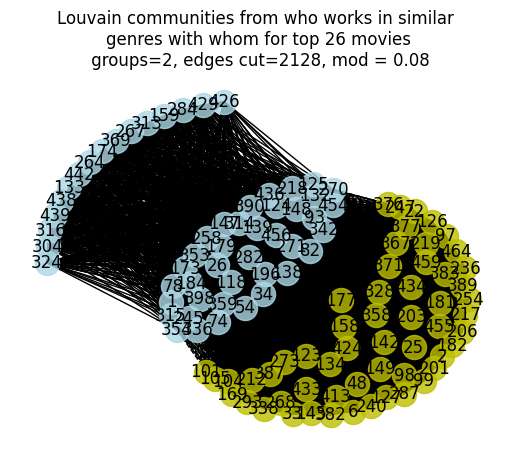

In [193]:
partition = nx.community.louvain_communities(largest_subgraph)
show_partitions(largest_subgraph, 
                partition, 
                title = "Louvain communities from who works in similar \ngenres with whom for top 26 movies\n")

---
---

#### Who Knows Whom

Let's construct the full person-knows-person graph. We'll begin by combining all writers, actors, and directors into a "person" category. This will allow me to fix a bug in the code above

In [197]:
categories: set[str] = {"name", "writers","directors","casts"}
G: nx.Graph = nx.Graph()
G, node_value_to_node_number = get_nodes_from_categories(categories,df,G)
G = add_edges(categories, node_value_to_node_number, df, G)
#show_graph(G, categories, title = "All movies")

Find who knows whom

In [199]:
G_name_person: nx.Graph = nx.Graph()
person_types: set[str] = {"directors", "casts", "writers"}
categories: set[str] = {"name"} | person_types # notice that this is now an ordered object
G_name_person: nx.Graph = nx.Graph()
G_name_person, node_value_to_node_number = get_nodes_from_categories(categories, df, G_name_person) 
G_name_person = add_edges(categories, node_value_to_node_number, df, G_name_person)

categories: list[str] = ["name","person"]
for node, attrs in G_name_person.nodes(data=True):
    if set(attrs.get("node_type").split(",")) <= person_types: # <= is shorthand for is subset
        attrs["node_type"] = "person"
B_name_person = get_biadjacency_matrix(G_name_person, categories)
A = B_name_person.T@B_name_person
np.fill_diagonal(A, 0)
A[A > 1] = 1

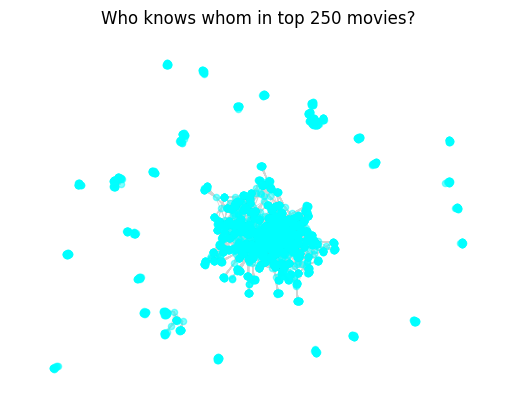

In [200]:
G_person_person: nx.Graph  = nx.from_numpy_array(A)
plt.figure()
pos = nx.spring_layout(G_person_person)
#pos = nx.nx_pydot.graphviz_layout(G_person_person)
#pos = nx.kamada_kawai_layout(G_person_person)
nx.draw_networkx_nodes(G_person_person, pos, node_color = 'cyan', alpha=0.5,node_size=20 )
nx.draw_networkx_edges(G_person_person, pos, edge_color="lightgray", width=0.5)
_ = plt.title("Who knows whom in top 250 movies?")
_ = plt.axis('off')

Largest component

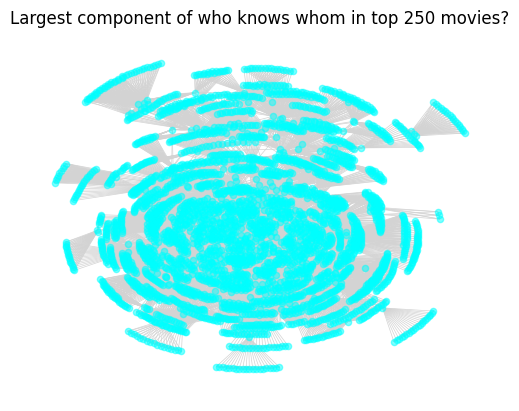

In [201]:
largest_cc = max(nx.connected_components(G_person_person), key=len)

# Create a subgraph with only the largest component
largest_subgraph = G_person_person.subgraph(largest_cc).copy()
plt.figure()
pos = nx.nx_pydot.graphviz_layout(largest_subgraph, prog="neato") # comment out if you don't want to wait a long time
#pos = nx.spring_layout(G_person_person) # comment out if you want to use graphviz or positions from previous cell
nx.draw_networkx_nodes(largest_subgraph, pos, node_color = 'cyan', alpha=0.5,node_size=20 )
nx.draw_networkx_edges(largest_subgraph, pos, edge_color="lightgray", width=0.5)
_ = plt.title("Largest component of who knows whom in top 250 movies?")
_ = plt.axis('off')

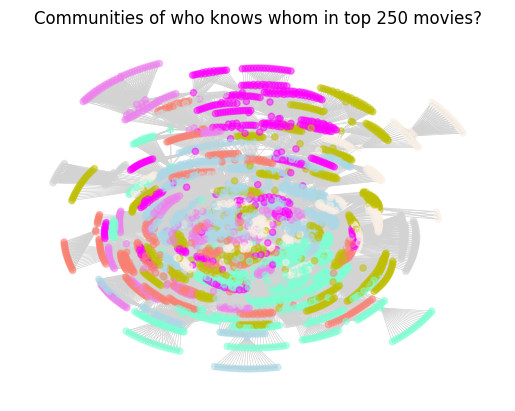

In [203]:
partition = nx.community.louvain_communities(largest_subgraph)
color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'magenta', 'lightgray', 'linen']
node_color: list[str] = []
for node in largest_subgraph:
    for i in range(len(partition)):
        if node in partition[i]: 
            node_color.append(color_list[i%len(color_list)])
            continue
nx.draw_networkx_nodes(largest_subgraph, pos, node_color = node_color, alpha=0.5,node_size=20 )
nx.draw_networkx_edges(largest_subgraph, pos, edge_color="lightgray", width=0.5)
_ = plt.title("Communities of who knows whom in top 250 movies?")
_ = plt.axis('off')

Which  nodes are central?

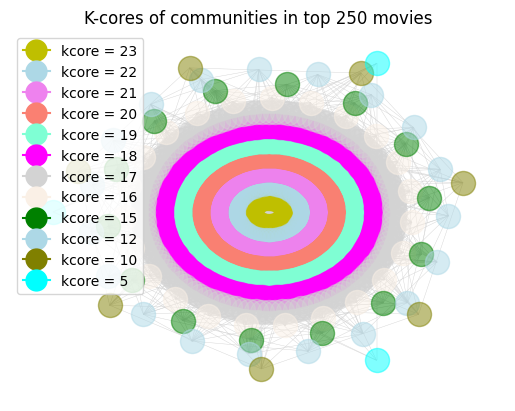

In [215]:
#%load_ext autoreload
%autoreload 2
from drawing_utilities import show_kCores
show_kCores(largest_subgraph, title = "K-cores of communities in top 250 movies")

How about pagerank centrality?

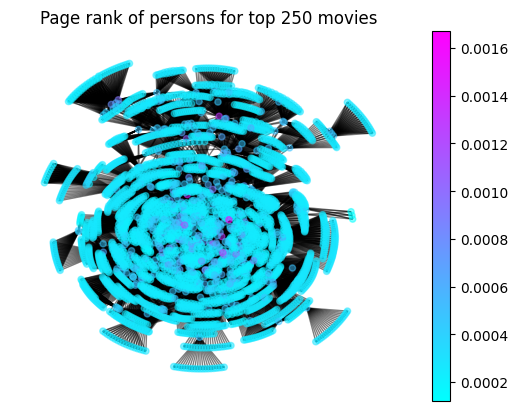

In [226]:
%autoreload 2
from drawing_utilities import show_graph_by_pagerank
show_graph_by_pagerank(largest_subgraph,
                       pos = pos,
                       title = "Page rank of persons for top 250 movies",
                       show_scale = True,
                       show_labels=False)

---
---